# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho = 1.0  # Density
mu = 1e-3  # Viscosity
U_mean = 1.0 # Mean inflow velocity
Re = rho * U_mean * D / mu
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [9]:
from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 18, 18
# NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging
h  = 0.5*(L/NX + H/NY)
# box = (c_x-3*h, c_y-3*h, c_x+3*h, c_y+3*h)
window = (c_x-D*1.5, c_y-D*1.5, c_x+D*1.5, c_y+D*1.5)  # grid-aligned selection window

# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=level_set,max_refine_level=5)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---
bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}


# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [10]:
# --- Level Set for the Cylinder Obstacle ---


mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = get_domain_bitset(mesh, "edge", "ghost")
physical_domain = fluid_domain | cut_domain

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 'p': 1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {ghost_edges.cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")


=== DofHandler (CG) ===
        ux: 13085 DOFs @ offset 0
        uy: 13085 DOFs @ offset 9
         p: 3402 DOFs @ offset 18
  total : 29572
Number of interface edges: 345
Number of ghost edges: 298
Number of cut elements: 300


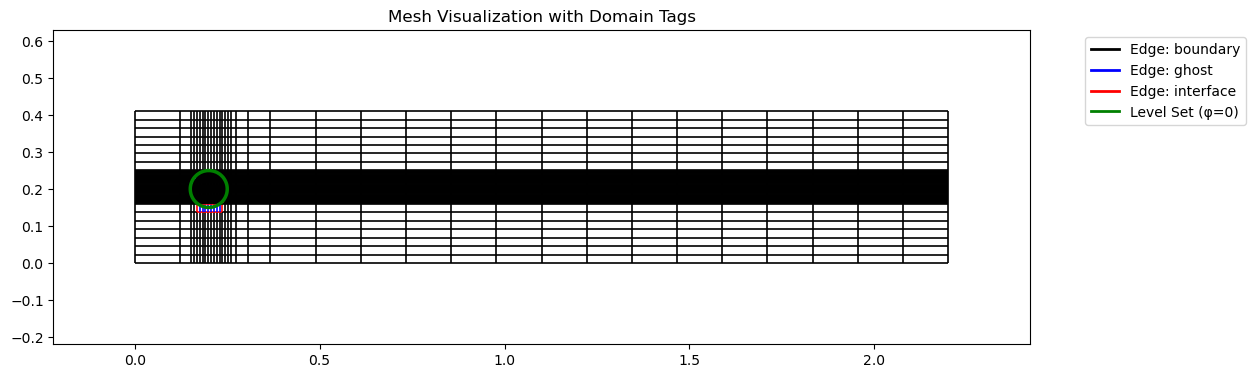

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [11]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [12]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_space = FunctionSpace(name="velocity", field_names=['ux', 'uy'],dim=1)
pressure_space = FunctionSpace(name="pressure", field_names=['p'], dim=0)

# Trial and Test functions
du = VectorTrialFunction(space=velocity_space, dof_handler=dof_handler)
dp = TrialFunction(name='trial_pressure', field_name='p', dof_handler=dof_handler)
v = VectorTestFunction(space=velocity_space, dof_handler=dof_handler)
q = TestFunction(name='test_pressure', field_name='p', dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.02)
theta = Constant(1.0) # Crank-Nicolson
mu_const = Constant(mu)
rho_const = Constant(rho)

u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_n' as separate contour plots...


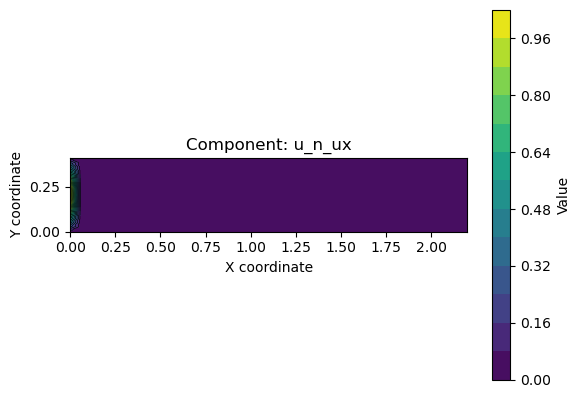

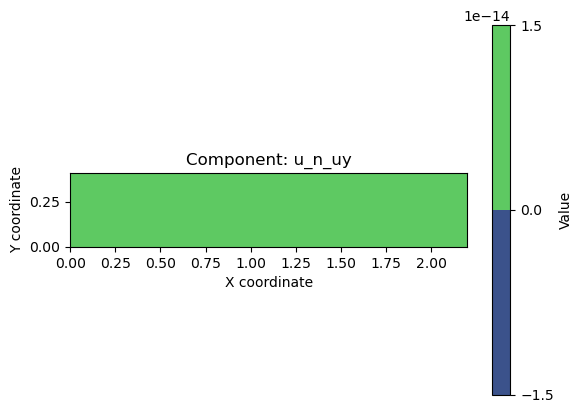

In [13]:
u_n.plot()

In [14]:
print(len(dof_handler.get_dirichlet_data(bcs)))

586


In [15]:
from pycutfem.ufl.expressions import Derivative, FacetNormal
n = FacetNormal()                    # vector expression (n_x, n_y)

def _dn(expr):
    """Normal derivative  n·∇expr  on an (interior) edge."""
    return n[0] * Derivative(expr, 1, 0) + n[1] * Derivative(expr, 0, 1)
    # return dot(grad(expr), n)

def grad_inner(u, v):
    """⟨∂ₙu, ∂ₙv⟩  (scalar or 2‑D vector)."""
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _dn(u) * _dn(v)

    if u.num_components == v.num_components == 2: # vector
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])

    raise ValueError("grad_inner supports only scalars or 2‑D vectors.")

dx_phys  = dx(defined_on=physical_domain,metadata={"q":6})               # volume
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set, metadata={"q":4})   # interior surface
dG       = dGhost(defined_on=mesh.edge_bitset("ghost"), level_set=level_set,metadata={"q":4})  # ghost surface

cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(10.0 * poly_order**2)      # Nitsche penalty (tweak)

def epsilon(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)

def sigma_dot_n(u_vec, p_scal):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return mu * (a + b) - p_scal * n         # vector of size 2

def sigma_dot_n_v(u_vec, p_scal,v_test):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return mu * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du, dp, v)           # consistency
    - sigma_dot_n_v(v, q, du)           # symmetry
    + beta_N * mu / cell_h * dot(du, v)     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(u_k, p_k, v)
    - sigma_dot_n_v(v, q, u_k)
    + beta_N * mu / cell_h * dot(u_k, v)
) * dΓ

# volume ------------------------------------------------------------
a_vol = ( rho*dot(du,v)/dt
          + theta*rho*dot(dot(grad(u_k), du), v)
          + theta*rho*dot(dot(grad(du), u_k), v)
          + theta*mu*inner(grad(du), grad(v))
          - dp*div(v) + q*div(du) ) * dx(defined_on=physical_domain,metadata={q:6}) 

r_vol = ( rho*dot(u_k-u_n, v)/dt
          + theta*rho*dot(dot(grad(u_k), u_k), v)
          + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
          + theta*mu*inner(grad(u_k), grad(v))
          + (1-theta)*mu*inner(grad(u_n), grad(v))
          - p_k*div(v) + q*div(u_k) ) * dx(defined_on=physical_domain,metadata={q:6}) 
          
# ghost stabilisation (add exactly as in your Poisson tests) --------
penalty_val = 10
penalty_grad = 0.1
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad= Constant(penalty_grad * poly_order**2)
gamma_p  = Constant(penalty_val * poly_order**1)
gama_p_grad = Constant(penalty_grad * poly_order**1)

# stab      = ( gamma_v  / cell_h   * dot(jump(u_k), jump(v))
#             + gamma_v_grad * cell_h   * grad_inner(jump(u_k), jump(v))) * dG

stab_lin  = ( gamma_v  / cell_h   * dot(jump(du),  jump(v)) +
             gamma_v_grad * cell_h   * grad_inner(jump(du),  jump(v))) * dG
stab_lin += ( gamma_p  / cell_h   * dot(jump(dp),  jump(q))
            + gama_p_grad * cell_h   * grad_inner(jump(dp),  jump(q))) * dG
# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol + J_int + stab_lin
residual_form  = r_vol + R_int 
# residual_form  = dot(  Constant(np.array([0.0, 0.0]),dim=1), v) * dx
# jacobian_form  = stab_lin
# residual_form  = stab





In [16]:
!rm ~/.cache/pycutfem_jit/*

rm: cannot remove '/home/jamal/.cache/pycutfem_jit/__pycache__': Is a directory


In [17]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [ ]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters, AdamNewtonSolver
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")


# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=36 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=False),
)
# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

JIT cache miss → compiling _pycutfem_kernel_708a50512f0d6d2af4a7a3f900450c9e17c4f47d8d73b6d630fe2a77f07f81e9.py
JIT cache miss → compiling _pycutfem_kernel_eea075220d775e86755595b989e4bec6b6398b03878983c830f23abb4651d039.py
JIT cache miss → compiling _pycutfem_kernel_272f1b02cf48a56be00a14c64c2baabca777fc6b1855e4fcf6989ce5bf37dbae.py
JIT cache miss → compiling _pycutfem_kernel_3468f58d3490365ce734041e502ff1c59a0e2febe23b600fb4ccb67a2dcc78c5.py
JIT cache miss → compiling _pycutfem_kernel_04443c4191198399a7e09a996d10c9efc780028465b92886785e47bfb929f675.py
JIT cache miss → compiling _pycutfem_kernel_49098c84e01d3c2eaa1ce24bd1a40670f1a0bb3a870d46d781c4dc28d1624a60.py
volume   : |R|_∞ = 1.683e-02
interface: |R|_∞ = 1.041e-02
        Newton 1: |R|_∞ = 1.68e-02
volume   : |R|_∞ = 6.482e-01
interface: |R|_∞ = 2.436e-02
        Newton 2: |R|_∞ = 1.41e-02
volume   : |R|_∞ = 7.069e-01
interface: |R|_∞ = 2.860e-02
        Newton 3: |R|_∞ = 3.61e-03
volume   : |R|_∞ = 7.151e-01
interface: |R|_∞ = 2

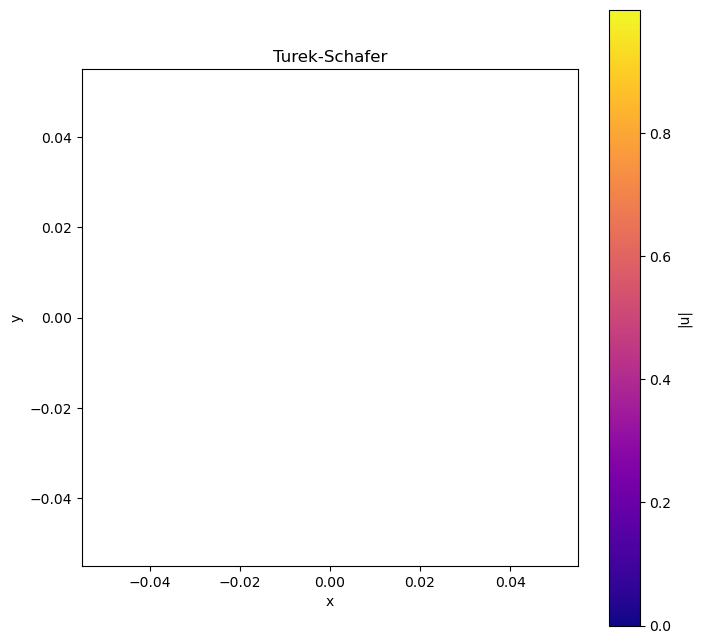

In [ ]:
u_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Turek-Schafer",background = False)